`wu_fuzzy_NN_training.ipynb`

> Using data from `wu_fuzzy_rand_tau_rand_phase.csv`

In [1]:
import pandas as pd, tensorflow as tf,  matplotlib.pyplot as plt, sys
from sklearn.preprocessing import MinMaxScaler

from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter
from plot_styles import set_plotstyles
set_plotstyles()
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/andrew/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#import data
data_path_1 = 'data/wu_fuzzy_rand_tau_rand_phase.csv'
data_df_1 = pd.read_csv(data_path_1, dtype = float)

# split random 80% / 10%
training_data_df_1 = data_df_1.sample(frac = 0.8)
testing_data_df_1 = data_df_1.loc[~data_df_1.index.isin(training_data_df_1.index)]

# separate input features from output
X_training_1 = training_data_df_1.drop('slope', axis = 1).values
Y_training_1 = training_data_df_1[['slope']].values

X_testing_1 = testing_data_df_1.drop('slope', axis = 1).values
Y_testing_1 = testing_data_df_1[['slope']].values

# setup data scalers
X_scaler_1 = MinMaxScaler(feature_range = (0,1))
Y_scaler_1 = MinMaxScaler(feature_range = (0,1))

# scale data
X_scaled_training_1 = X_scaler_1.fit_transform(X_training_1)
Y_scaled_training_1 = Y_scaler_1.fit_transform(Y_training_1)

X_scaled_testing_1 = X_scaler_1.transform(X_testing_1)
Y_scaled_testing_1 = Y_scaler_1.transform(Y_testing_1)

In [3]:
number_of_inputs = X_scaled_training_1.shape[1]
number_of_outputs = Y_scaled_training_1.shape[1]

In [34]:
num_layers = 5
r = (number_of_inputs/number_of_outputs)**(1/(num_layers + 1))

layer_1_nodes = int(number_of_outputs * r**(num_layers - 1))
layer_2_nodes = int(number_of_outputs * r**(num_layers - 2))
layer_3_nodes = int(number_of_outputs * r**(num_layers - 3))
layer_4_nodes = int(number_of_outputs * r**(num_layers - 4))
layer_5_nodes = int(number_of_outputs * r**(num_layers - 5))


learning_rate = 0.0015
training_epochs = 500

In [36]:
# change log path
logdir = str(layer_1_nodes) + '_' + str(layer_2_nodes) + '_' + str(layer_3_nodes) + '_' + str(layer_4_nodes) + '_' + str(layer_5_nodes)
logdir += '_a_relu'
logdir

'101_31_10_3_1_a_relu'

In [37]:
tf.reset_default_graph()

In [38]:
# Input Layer
with tf.variable_scope('input'):
    X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))

# Layer 1
with tf.variable_scope('layer_1'):

    biases = tf.get_variable(name = "biases1",
                             shape = [layer_1_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights1",
                              shape  = [number_of_inputs, layer_1_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):

    biases = tf.get_variable(name = "biases2",
                             shape = [layer_2_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights2",
                              shape  = [layer_1_nodes, layer_2_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):

    biases = tf.get_variable(name = "biases3",
                             shape = [layer_3_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights3",
                              shape  = [layer_2_nodes, layer_3_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Layer 4
with tf.variable_scope('layer_4'):

    biases = tf.get_variable(name = "biases4",
                             shape = [layer_4_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights4",
                              shape  = [layer_3_nodes, layer_4_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_4_output = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)


# Layer 5
with tf.variable_scope('layer_5'):

    biases = tf.get_variable(name = "biases5",
                             shape = [layer_5_nodes],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights5",
                              shape  = [layer_4_nodes, layer_5_nodes],
                         initializer = tf.contrib.layers.xavier_initializer())


    layer_5_output = tf.nn.relu(tf.matmul(layer_4_output, weights) + biases)



# Output layer

with tf.variable_scope('output'):

    biases = tf.get_variable(name = "biases_out",
                             shape = [number_of_outputs],
                             initializer = tf.zeros_initializer())

    weights = tf.get_variable(name = "weights_out",
                              shape  = [layer_5_nodes, number_of_outputs],
                         initializer = tf.contrib.layers.xavier_initializer())


    prediction = tf.nn.relu(tf.matmul(layer_5_output, weights) + biases)

with tf.variable_scope('cost'):

    Y = tf.placeholder(tf.float32, shape = (None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))


with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(cost)

with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()
    

In [39]:
saver = tf.train.Saver()

In [40]:
with tf.Session() as session:

    session.run(tf.global_variables_initializer())

    training_writer = tf.summary.FileWriter('logs/' + logdir + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + '/testing', session.graph)

    for epoch in range(training_epochs):

        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training_1, Y: Y_scaled_training_1})

        training_feed = {X: X_scaled_training_1, Y: Y_scaled_training_1}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing_1, Y: Y_scaled_testing_1}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, testing_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + '_model' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

 epoch:  499 testing_cost: 0.0321918949

In [42]:
with tf.Session() as session:
    saver.restore(session,'logs/101_31_10_3_1_a_relu_model/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing_1})
    
    # the predictions but in the original units
    prediction_unscaled = Y_scaler_1.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/101_31_10_3_1_a_relu_model/trained_model.ckpt


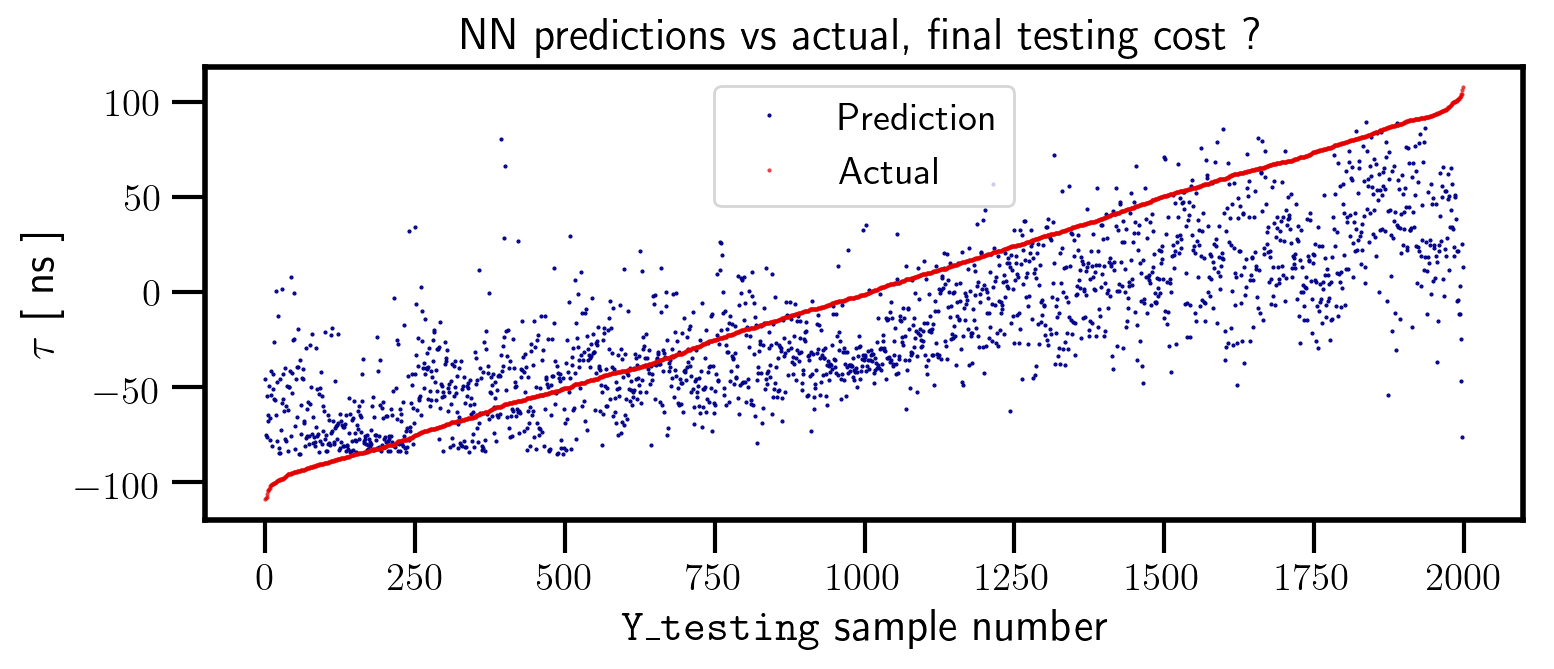

In [45]:
sorting_idx = np.argsort(Y_testing_1.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title('NN predictions vs actual, final testing cost ?')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(Y_testing_1.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [47]:
NN_SCORE = sum((Y_scaled_testing_1.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

64.38379402248873

In [49]:
np.std(abs(Y_testing_1.T[0] - prediction_unscaled.T[0]))

23.686017767530785

In [51]:
np.mean(abs(Y_testing_1.T[0] - prediction_unscaled.T[0]))

30.99002087341541

In [52]:
with tf.Session() as session:

#     session.run(tf.global_variables_initializer())
    saver.restore(session,'logs/101_31_10_3_1_a_relu_model/trained_model.ckpt')
    training_writer = tf.summary.FileWriter('logs/' + logdir + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + '/testing', session.graph)

    for epoch in range(training_epochs):
        epoch = epoch + training_epochs
        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training_1, Y: Y_scaled_training_1})

        training_feed = {X: X_scaled_training_1, Y: Y_scaled_training_1}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing_1, Y: Y_scaled_testing_1}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, testing_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + '_model' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

INFO:tensorflow:Restoring parameters from logs/101_31_10_3_1_a_relu_model/trained_model.ckpt
 epoch:  999 testing_cost: 0.0091841705

In [53]:
with tf.Session() as session:
    saver.restore(session,'logs/101_31_10_3_1_a_relu_model/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing_1})
    
    # the predictions but in the original units
    prediction_unscaled = Y_scaler_1.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/101_31_10_3_1_a_relu_model/trained_model.ckpt


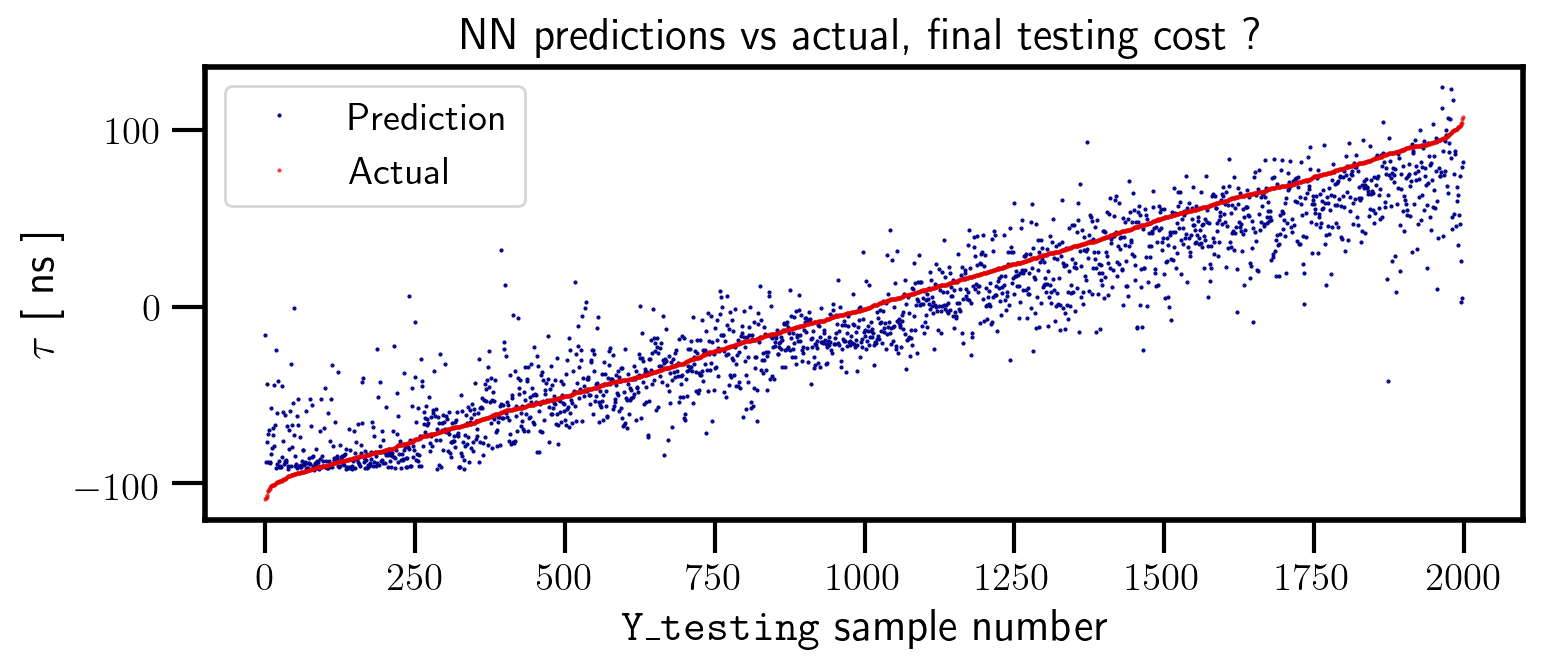

In [54]:
sorting_idx = np.argsort(Y_testing_1.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title('NN predictions vs actual, final testing cost ?')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(Y_testing_1.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [55]:
NN_SCORE = sum((Y_scaled_testing_1.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

18.36834082486732

In [56]:
np.std(abs(Y_testing_1.T[0] - prediction_unscaled.T[0]))

14.026356601802963

In [57]:
np.mean(abs(Y_testing_1.T[0] - prediction_unscaled.T[0]))

15.404896933547041

In [58]:
#import data
data_path_2 = 'data/wu_fuzzy_rand_tau_rand_phase_more_noise.csv'
data_df_2 = pd.read_csv(data_path_2, dtype = float)

# split random 80% / 10%
training_data_df_2 = data_df_2.sample(frac = 0.8)
testing_data_df_2 = data_df_2.loc[~data_df_2.index.isin(training_data_df_2.index)]

# separate input features from output
X_training_2 = training_data_df_2.drop('slope', axis = 1).values
Y_training_2 = training_data_df_2[['slope']].values

X_testing_2 = testing_data_df_2.drop('slope', axis = 1).values
Y_testing_2 = testing_data_df_2[['slope']].values

# setup data scalers
X_scaler_2 = MinMaxScaler(feature_range = (0,1))
Y_scaler_2 = MinMaxScaler(feature_range = (0,1))

# scale data
X_scaled_training_2 = X_scaler_2.fit_transform(X_training_2)
Y_scaled_training_2 = Y_scaler_2.fit_transform(Y_training_2)

X_scaled_testing_2 = X_scaler_2.transform(X_testing_2)
Y_scaled_testing_2 = Y_scaler_2.transform(Y_testing_2)

In [61]:
with tf.Session() as session:

    saver.restore(session,'logs/101_31_10_3_1_a_relu_model/trained_model.ckpt')


    training_writer = tf.summary.FileWriter('logs/' + logdir + '_more_noise' + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + '/testing', session.graph)

    for epoch in range(training_epochs):
        epoch = epoch + 2 * training_epochs
        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training_1, Y: Y_scaled_training_1})

        training_feed = {X: X_scaled_training_1, Y: Y_scaled_training_1}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing_1, Y: Y_scaled_testing_1}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, testing_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + '_model_more_noise' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

INFO:tensorflow:Restoring parameters from logs/101_31_10_3_1_a_relu_model/trained_model.ckpt
 epoch: 1499 testing_cost: 0.0060171392

In [62]:
with tf.Session() as session:
    saver.restore(session,'logs/101_31_10_3_1_a_relu_model_more_noise/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing_1})
    
    # the predictions but in the original units
    prediction_unscaled = Y_scaler_1.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/101_31_10_3_1_a_relu_model_more_noise/trained_model.ckpt


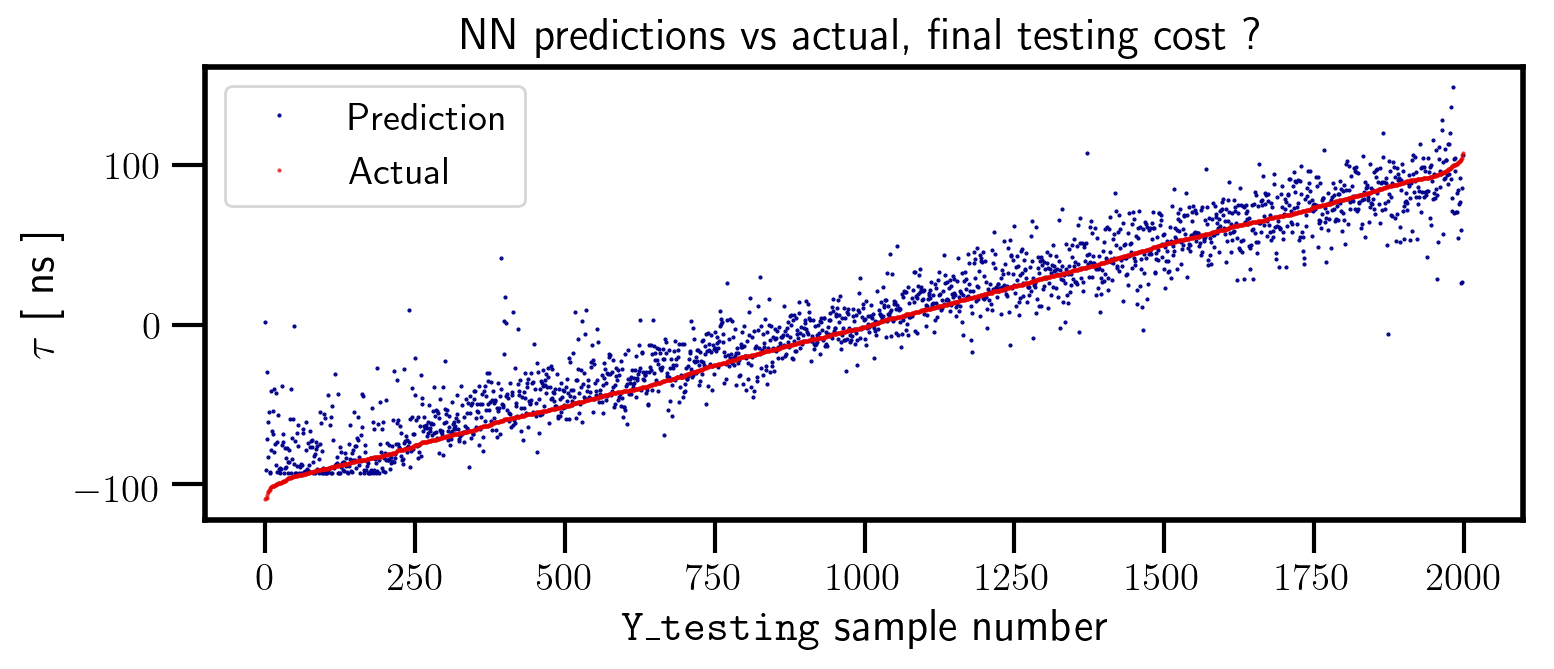

In [63]:
sorting_idx = np.argsort(Y_testing_1.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title('NN predictions vs actual, final testing cost ?')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(Y_testing_1.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [64]:
NN_SCORE = sum((Y_scaled_testing_1.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

12.034276360285524

In [65]:
np.std(abs(Y_testing_1.T[0] - prediction_unscaled.T[0]))

11.680384729284512

In [66]:
np.mean(abs(Y_testing_1.T[0] - prediction_unscaled.T[0]))

12.163151929893036

In [67]:
with tf.Session() as session:

    saver.restore(session,'logs/101_31_10_3_1_a_relu_model/trained_model.ckpt')

    training_writer = tf.summary.FileWriter('logs/' + logdir + '_more_noise' + '/training', session.graph)
    testing_writer = tf.summary.FileWriter('logs/' + logdir + '_more_noise' + '/testing', session.graph)

    for epoch in range(training_epochs):
        epoch = epoch + 3 * training_epochs
        # Feed in the training data and do one stepf NN training
        session.run(optimizer,
                    feed_dict = {X: X_scaled_training_1, Y: Y_scaled_training_1})

        training_feed = {X: X_scaled_training_1, Y: Y_scaled_training_1}
        training_cost, training_summary = session.run([cost, summary],
                                                feed_dict = training_feed)

        testing_feed =  {X: X_scaled_testing_1, Y: Y_scaled_testing_1}
        testing_cost, testing_summary = session.run([cost, summary],
                                                     feed_dict = testing_feed)
        sys.stdout.write('\r epoch: {:4.0f} testing_cost: {:2.10f}'.format(epoch, testing_cost))
        
        training_writer.add_summary(training_summary, epoch)
        testing_writer.add_summary(testing_summary, epoch)
        testing_writer.flush()
        training_writer.flush()

    model_save_location = 'logs/' + logdir + '_model_more_noise_2' + '/trained_model.ckpt'
    save_path = saver.save(session, model_save_location)

INFO:tensorflow:Restoring parameters from logs/101_31_10_3_1_a_relu_model/trained_model.ckpt
 epoch: 1999 testing_cost: 0.0060171392

In [74]:
with tf.Session() as session:
    saver.restore(session,'logs/101_31_10_3_1_a_relu_model_more_noise_2/trained_model.ckpt')
    
    prediction_scaled = session.run(prediction, feed_dict = {X: X_scaled_testing_1})
    
    # the predictions but in the original units
    prediction_unscaled = Y_scaler_1.inverse_transform(prediction_scaled)

INFO:tensorflow:Restoring parameters from logs/101_31_10_3_1_a_relu_model_more_noise_2/trained_model.ckpt


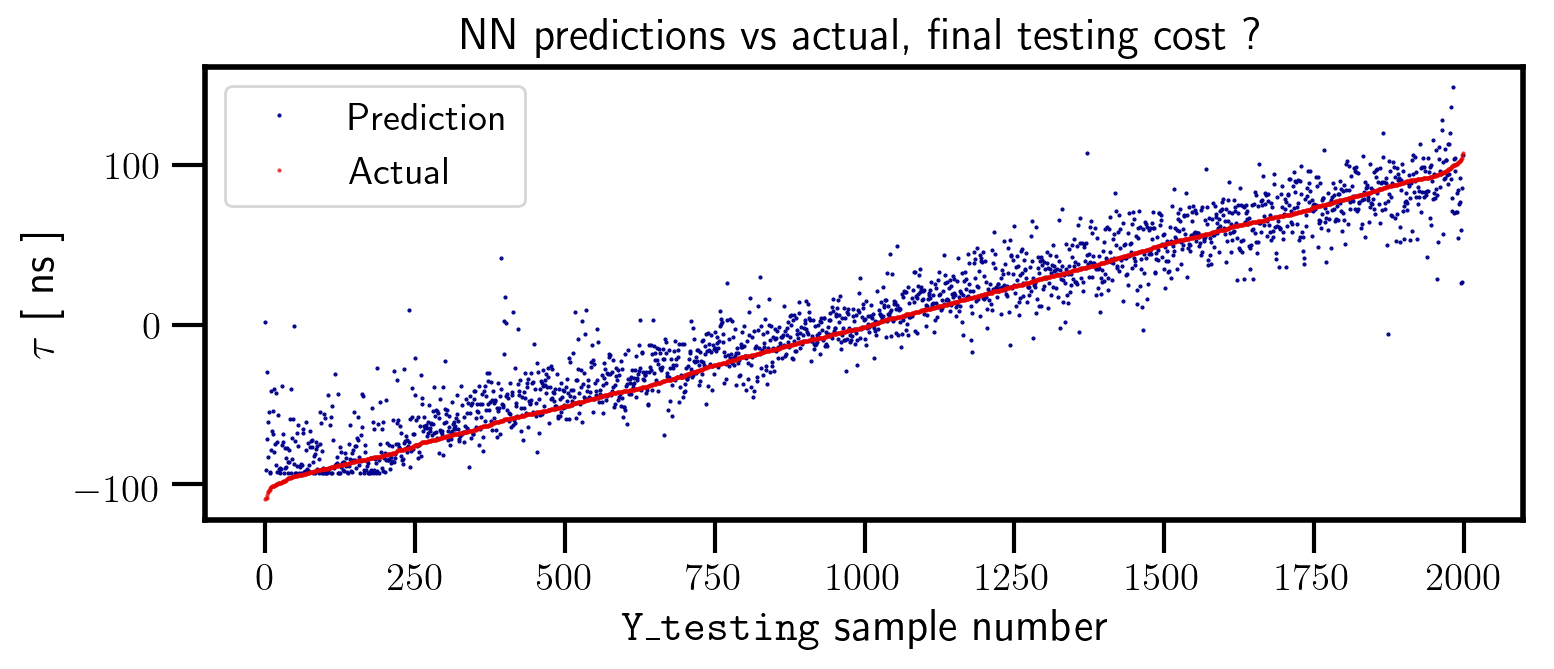

In [75]:
sorting_idx = np.argsort(Y_testing_1.T[0])

fig, ax = plt.subplots(figsize = (8.5, 3), dpi = 100)

ax.set_title('NN predictions vs actual, final testing cost ?')
ax.plot(prediction_unscaled.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1,
        color = 'darkblue', label = 'Prediction')

ax.plot(Y_testing_1.T[0][sorting_idx],
        linestyle = 'none', marker = '.', markersize = 1, alpha = 0.75, 
        color = '#E50000', label = 'Actual')

ax.set_ylabel(r'$\tau$ [ ns ]')
ax.set_xlabel(r'$\texttt{Y\_testing}$ sample number')
ax.legend( loc = 'best')
plt.show()

In [76]:
NN_SCORE = sum((Y_scaled_testing_1.T[0] - prediction_scaled.T[0])**2)
NN_SCORE

12.034276360285524

In [77]:
np.std(abs(Y_testing_1.T[0] - prediction_unscaled.T[0]))

11.680384729284512

In [78]:
np.mean(abs(Y_testing_1.T[0] - prediction_unscaled.T[0]))

12.163151929893036